# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need

In [31]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = len("".join(tokens))
    
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return[i for i in tokens if i not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [32]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/ruddysimonpour/Desktop/University of Sandiego - Curriculum/ADS509 - Applied text analysis/ADS-509/Module-2/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}



In [33]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [34]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [35]:
# read in the lyrics here
lyrics_data = {}

artists = ['cher', 'robyn']

for artist in artists:
    lyrics_data[artist] = {}
    
    song_lists = os.listdir(data_location + lyrics_folder + str(artist))
    
    for song in song_lists:
        # Get the song titles and artist name by splitting the filename at the underscore
        song_title = os.path.splitext(song)[0].split('_')[1]
        
        with open(data_location + lyrics_folder + str(artist)+ '/' + str(song), 'r', encoding='utf-8') as file:
            lyrics_data[artist][song_title] = file.read()
            

In [36]:
data = []

for artist, songs in lyrics_data.items():
    for song_title, lyrics in songs.items():
        data.append([artist, song_title.replace('_', ' '), lyrics])

lyrics_data = pd.DataFrame(data, columns=['artist_name', 'song_title', 'lyrics'])

lyrics_data.head()


,artist_name,song_title,lyrics
0,cher,comeandstaywithme,"""Come And Stay With Me""\n\n\n\nI'll send away ..."
1,cher,pirate,"""Pirate""\n\n\n\nHe'll sail on with the summer ..."
2,cher,stars,"""Stars""\n\n\n\nI was never one for saying what..."
3,cher,thesedays,"""These Days""\n\n\n\nWell I've been out walking..."
4,cher,lovesohigh,"""Love So High""\n\n\n\nEvery morning I would wa..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [37]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [39]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [40]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3034606,cher,"28, Lab Scientist👨🏼‍🔬 ,homo 🌈 , LSU 🐯. Thats w...","[28, lab, scientist👨🏼‍🔬, homo, 🌈, lsu, 🐯, that..."
3467056,cher,#CaptainMarvel #RogueXmen #ScarletWitch #Potte...,"[#captainmarvel, #roguexmen, #scarletwitch, #p..."
2987624,cher,"Once Upon A Time,An Angel And A Devil Fell In ...","[upon, timean, angel, devil, fell, love, ♥♥, ♥♥]"
2776387,cher,"Lahey Clinic Burlington Single Mom, Master Est...","[lahey, clinic, burlington, single, mom, maste..."
1498158,cher,📸 snap: kybug9752 Instagram kyleigh_nelms😁,"[📸, snap, kybug9752, instagram, kyleighnelms😁]"
238933,cher,Producer 🎬 Feminist https://t.co/NRxSyLG8Fb,"[producer, 🎬, feminist, httpstconrxsylg8fb]"
2053736,cher,y justo cuando la oruga pensaba q el mundo se ...,"[justo, cuando, la, oruga, pensaba, q, el, mun..."
1829538,cher,"I live my life, because I dare. ✌️❤️Instagram:...","[live, life, dare, ✌️❤️instagram, joeyheide]"
2434013,cher,aspiring youtuber ☺️ i will film some videos s...,"[aspiring, youtuber, ☺️, film, videos, soon, h..."
273434,cher,Why are we reliant on the economy aka the gove...,"[reliant, economy, aka, government, 🤔👇, blog, ..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Emojis and special characters like 👨🏼‍🔬 and 🌈 are being treated as individual tokens. While this may be desirable in some cases, in other cases, you might want to remove emojis or encode them differently, perhaps converting them to a word representation of their meaning, especially if they do not contribute to the analysis.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [41]:
import nltk
import pandas as pd
nltk.download('punkt') 

artists = ['cher', 'robyn']

for artist in artists:
    artist_data = lyrics_data[lyrics_data['artist_name'] == artist]
    
    all_lyrics = " ".join(artist_data['lyrics'])
    
    tokens = nltk.word_tokenize(all_lyrics)
    
    print(f"Descriptive Statistics for {artist.capitalize()}:")
    descriptive_stats(tokens)  
    print("\n")  


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Descriptive Statistics for Cher:
There are 79284 tokens in the data.
There are 4676 unique tokens in the data.
There are 274999 characters in the data.
The lexical diversity is 0.059 in the data.


Descriptive Statistics for Robyn:
There are 33812 tokens in the data.
There are 2675 unique tokens in the data.
There are 117506 characters in the data.
The lexical diversity is 0.079 in the data.




Q: what observations do you make about these data? 

A: Cher has a substantially higher volume of content compared to Robyn, with 79,284 tokens and 274,999 characters.

Cher utilizes 4,676 unique tokens, which is notably more than Robyn’s 2,675 unique tokens.

The lexical diversity (the ratio of unique tokens to the total number of tokens) is higher for Robyn at 0.079 compared to Cher at 0.059. This suggests that, relative to the volume of content, Robyn has a more varied vocabulary.

Cher’s lower lexical diversity score indicates a higher degree of word repetition compared to Robyn, which can be interpreted as Cher using a more focused or limited set of vocabulary in her content.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [42]:
def calculate_token_statistics(tokens, min_count=5):
    count_corpora = {'token': [], 'count': [], 'concentration': []}
    counter = Counter(tokens)
    for t, count in counter.items():
        if count >= min_count:
            count_corpora['token'].append(t)
            count_corpora['count'].append(count)
            concentration = count / len(tokens)
            count_corpora['concentration'].append(concentration)
    return pd.DataFrame(count_corpora)

def flatten_nested_list(nested_list):
    return [element for inner_list in nested_list for element in inner_list]

def get_tokens_by_artist(lyrics_data, artist):
    tokens = lyrics_data.loc[lyrics_data['artist_name'] == artist, 'tokens']
    tokens = flatten_nested_list(list(tokens))
    return tokens


def main():
    cher_tokens = get_tokens_by_artist(lyrics_data, 'cher')
    cher_df = calculate_token_statistics(cher_tokens)
    cher_df.columns = ['token', 'corpus1 count', 'concentration1']
    
    robyn_tokens = get_tokens_by_artist(lyrics_data, 'robyn')
    robyn_df = calculate_token_statistics(robyn_tokens)
    robyn_df.columns = ['token', 'corpus2 count', 'concentration2']
    
    # Merge the two DataFrames
    final_df = cher_df.merge(robyn_df, on='token')
    
    return final_df


In [43]:
main()

,token,corpus1 count,concentration1,corpus2 count,concentration2
0,come,270,0.007452,72,0.004696
1,stay,78,0.002153,15,0.000978
2,ill,170,0.004692,73,0.004762
3,away,196,0.005410,39,0.002544
4,life,124,0.003422,39,0.002544
...,...,...,...,...,...
373,anytime,6,0.000166,8,0.000522
374,makin,5,0.000138,5,0.000326
375,boys,45,0.001242,6,0.000391
376,darkness,9,0.000248,5,0.000326


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Words like “come”, “stay”, “ill”, “away”, and “life” are common to both corpora, reflecting possibly common themes or topics discussed in the contents. 

The word “come” has a higher concentration in corpus1 than in corpus2, which might indicate different usage or importance of this word in the respective contents.

Words like “ill” and “life” have similar concentrations in both corpora, suggesting a similar level of emphasis or relevance in both contexts.

The variety in the concentration of different words between the two corpora suggests different styles, topics, or thematic elements. For instance, higher occurrences of words like “stay” and “away” in corpus1 may imply different narrative focuses or stylistic preferences compared to corpus2.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [44]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df[freq_df['freq'] >= min_freq]
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [45]:
# !pip install --upgrade pip
# !pip install --upgrade Pillow

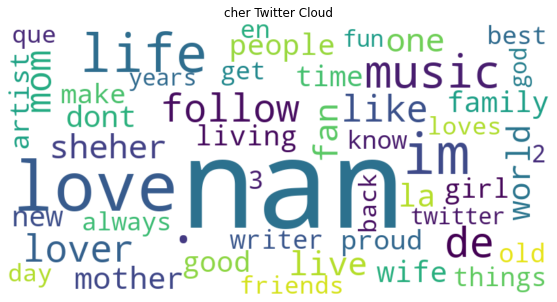

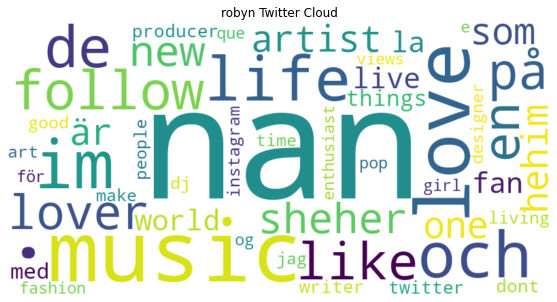

In [46]:
from wordcloud import WordCloud 

artists = ['cher', 'robyn']

min_freq = 5

for artist in artists:
    
    # for twitter
    twitter_data_wcloud = twitter_data[twitter_data['artist'] == artist]
  
    word_freq = count_words(twitter_data_wcloud, column='tokens', min_freq=min_freq)
    wc = WordCloud(background_color='white', max_words=50, width=800, height=400)
    twitter_wc = wc.generate_from_frequencies(word_freq['freq'])
        
    plt.figure(figsize=(10,5))
    plt.imshow(twitter_wc, interpolation='bilinear')
    plt.title(f'{artist} Twitter Cloud')
    plt.axis('off')
    plt.show()

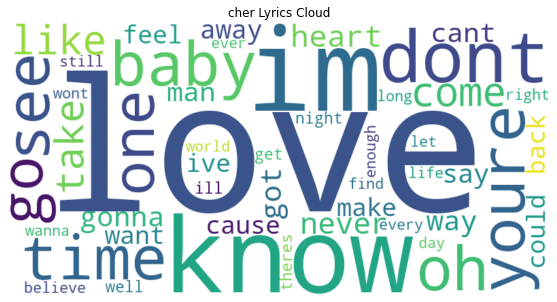

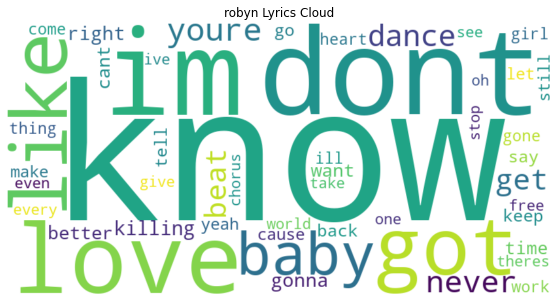

In [48]:
min_freq = 5

for artist in artists:
    # for lyrics
    lyrics_data_wcloud = lyrics_data[lyrics_data['artist_name'] == artist]
    word_freq = count_words(lyrics_data_wcloud, column='tokens', min_freq=5)

    lyrics_wc = wc.generate_from_frequencies(word_freq['freq'])

    plt.figure(figsize=(10,5))
    plt.imshow(lyrics_wc, interpolation='bilinear')
    plt.title(f'{artist} Lyrics Cloud')
    plt.axis('off')
    plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: We observe that certain words such as "Love," "Life," "Music," and "Follow" recur in the lyrics of both artists, suggesting that these terms might be prevalent in the music industry. While some words are common between the two, there are also distinctly different words and phrases evident in their music. Similarly, we notice the usage of common words in the Twitter posts of both artists.